In [2]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1155b8be0>,
      dtype=object)

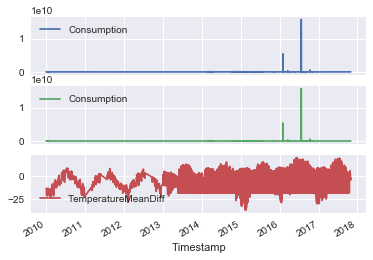

In [3]:
dataset = pd.read_csv('../data/processed/train_86400000000000.csv', parse_dates=[1])
dataset.set_index('Timestamp')[['Consumption', 'Consumption', 'TemperatureMeanDiff']].plot(subplots=True)

In [5]:
dataset['ConsumptionNormalized'] = dataset.groupby('SiteId')['Consumption'].transform(lambda v: (v-v.mean()) / v.std())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1159f4e10>,
      dtype=object)

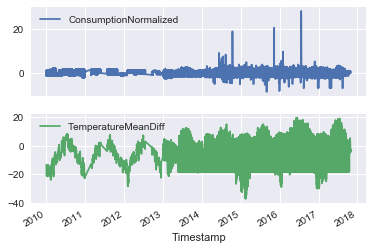

In [6]:
dataset.set_index('Timestamp')[['ConsumptionNormalized', 'TemperatureMeanDiff']].plot(subplots=True)

In [7]:
dataset['ConsumptionShift'] = dataset.groupby('ForecastId')['Consumption'].shift(59).values
dataset['ConsumptionTrend'] = dataset.groupby('ForecastId')['ConsumptionShift'].rolling(7*2, min_periods=7).mean().values
dataset['ConsumptionTrend'] = dataset.groupby('ForecastId')['ConsumptionTrend'].transform(lambda x: x.fillna(x[x.first_valid_index()])).values

In [8]:
features = [
    'IsMonthEnd', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'DayOfMonth_cos', 
    'DayOfMonth_sin', 'Quarter_cos', 'Quarter_sin', 'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
    'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations', 'TemperatureMeanDiff', 'TemperatureVariance', 
    'TemperatureMinDiff', 'TemperatureMaxDiff', 'HasTemperature', 'ConsumptionTrend', 'ConsumptionNormalized', 'SiteId'
]

ts = pd.get_dummies(dataset[features], columns=['SiteId'])

In [9]:
ts_x = ts.drop(columns=['ConsumptionNormalized'])
ts_y = ts['ConsumptionNormalized']
ts_fids = dataset['ForecastId']

ts_fids.value_counts()

982     360
3314    360
5330    360
6149    360
6962    360
5235    360
3312    360
1649    360
1905    360
3396    360
5255    360
1650    360
6726    360
6470    360
3154    360
5233    360
3442    360
4292    360
5238    360
6006    360
4599    360
2804    360
6966    360
3316    360
4294    360
6151    360
3234    360
6004    360
2358    360
407     360
       ... 
878      90
4271     90
6254     90
5230     90
651      90
2807     90
4265     90
6152     90
5256     90
6729     90
1513     90
649      90
2926     90
1391     90
880      90
5234     90
3313     90
3155     90
5232     90
3315     90
1906     90
6256     90
1651     90
2805     90
6967     90
3317     90
5239     90
6007     90
2359     90
6467     90
Name: ForecastId, Length: 224, dtype: int64

In [10]:
import math

input_window_size = 75
output_window_size = 59
frequency = np.timedelta64(1, 'D')

In [12]:
def generate_test_train_split(x, y, forecast_ids, input_window_size, output_window_size, test_size=0.2):
    min_test_size = (output_window_size) * 2
    fids, counts = np.unique(forecast_ids, return_counts=True)
    
    num_forecasts_for_test = round(fids.shape[0]*test_size)
    testable_fids = fids[np.where(counts >= min_test_size)]
    
    test_fids = np.random.choice(testable_fids, num_forecasts_for_test)
    
    test_mask = np.repeat([False], forecast_ids.shape[0])
    
    test_size = output_window_size
    for fid in test_fids:
        indices,  = np.where(forecast_ids == fid)
        test_mask[indices[-test_size:]] = True
            
    train_mask = np.logical_not(test_mask)
    
    return x[train_mask], y[train_mask], forecast_ids[train_mask], x[test_mask], y[test_mask], forecast_ids[test_mask]
    
ts_xtrain, ts_ytrain, ts_ftrain, ts_xtest, ts_ytest, ts_ftest = generate_test_train_split(ts_x, ts_y, ts_fids, input_window_size, output_window_size)

print(ts_xtrain.shape, ts_ytrain.shape)
print(ts_xtest.shape, ts_xtest.shape)

(50942, 112) (50942,)
(1888, 112) (1888, 112)


In [13]:
def generate_train_forecast_ts(x, y, input_window_size, output_window_size, pad=True):
    assert x.shape[0] == y.shape[0]
    
    min_size = output_window_size
    input_size = x.shape[0]
    
    if input_size < min_size and pad:
        num_pads = min_size - input_size
        
        x_pad = np.zeros((num_pads, x.shape[1]))
        y_pad = np.zeros((num_pads, y.shape[1]))
        x = np.vstack((x_pad, x))
        y = np.vstack((y_pad, y))
        
    assert x.shape[0] >= min_size
        
    num_samples = x.shape[0] - output_window_size + 1
    
    x_res = []
    y_res = []

    for i in range(num_samples):  
        x_res.append(x[i:i+output_window_size])
        y_res.append(y[i:i+output_window_size].reshape(-1, 1))

    return np.array(x_res), np.array(y_res)


def generate_train_ts(x, y, forecast_ids, input_window_size, output_window_size):
    assert x.shape[0] == y.shape[0]
    assert y.shape[0] == forecast_ids.shape[0]
    
    ids = np.unique(forecast_ids)
    
    agg_x = []
    agg_y = []
    for fid in tqdm(ids):
        fx = x[forecast_ids == fid, :]
        fy = y[forecast_ids == fid, :]
                
        fx_res , fy_res = generate_train_forecast_ts(fx, fy, input_window_size, output_window_size)
        
        agg_x.append(fx_res)
        agg_y.append(fy_res)
        
    agg_x = np.concatenate(agg_x)
    agg_y = np.concatenate(agg_y)
    
    return agg_x, agg_y



In [14]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()


tx_train, ty_train = generate_train_ts(
    scaler_x.fit_transform(ts_xtrain.values), 
#     ts_ytrain.values.reshape(-1, 1),
    scaler_y.fit_transform(ts_ytrain.values.reshape(-1, 1)), 
    ts_ftrain.values, 
    input_window_size, output_window_size
)

tx_test, ty_test = generate_train_ts(
    scaler_x.transform(ts_xtest.values),
#     ts_ytest.values.reshape(-1, 1),
    scaler_y.transform(ts_ytest.values.reshape(-1, 1)),
    ts_ftest.values,
    input_window_size, output_window_size
)

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
100%|██████████| 32/32 [00:00<00:00, 13056.20it/s]


In [25]:
from keras.layers import Dense, LSTM, TimeDistributed, Dropout
from keras.models import Sequential

def build_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, dropout=0.1, recurrent_dropout=0.3, batch_input_shape=(None, x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units=150, return_sequences=True, activation='relu', dropout=0.1, recurrent_dropout=0.3))
    model.add(TimeDistributed(Dense(units=1, activation='linear')))
    model.compile(loss='mse', optimizer='adam')

    return model

model = build_model(tx_train, ty_train)

In [26]:
from keras.callbacks import EarlyStopping

history = model.fit(tx_train, ty_train, validation_data=(tx_test, ty_test), epochs=200, callbacks=[
    EarlyStopping(patience=10)
], batch_size=500, shuffle=True)

plt.plot(history.epoch, history.history['loss'], color='blue', label='train')
plt.plot(history.epoch, history.history['val_loss'], color='green', label='test')

Train on 37950 samples, validate on 32 samples
Epoch 1/200
37950/37950 [==============================] - 121s 3ms/step - loss: 0.8275 - val_loss: 0.7412
Epoch 2/200
37950/37950 [==============================] - 129s 3ms/step - loss: 361.6924 - val_loss: 0.7211
Epoch 3/200
15500/37950 [===========>..................] - ETA: 1:13 - loss: 286739614341620.1250

KeyboardInterrupt: 

In [18]:
def _nwrmse(y_truth, y_pred, scaler_y):
    errors = []

    for i in range(y_truth.shape[0]):
        forecast_y_pred = scaler_y.inverse_transform(y_pred[i, :].ravel())[:-6]
        forecast_y_truth = scaler_y.inverse_transform(y_truth[i, :].ravel())[:-6]
        
        count = 200
        weights = (3 * count - 2 * np.arange(1, count + 1) + 1) / (2 * count ** 2)
        weights = weights[:forecast_y_pred.shape[0]]
        
        error = np.sqrt(np.sum(((forecast_y_truth - forecast_y_pred) ** 2) * weights))
        mean_error = error / np.average(forecast_y_truth)
        errors.append(mean_error)

    return np.average(errors)

y_pred = model.predict(tx_test)
_nwrmse(ty_test, y_pred, scaler_y)

5.379882379211688

(59, 1)
(32, 59, 1)


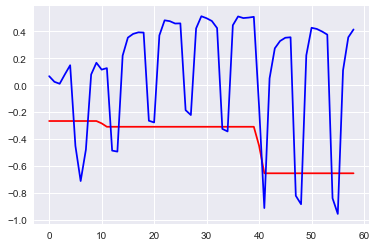

In [22]:
y_p = y_pred[-4, :]
print(y_p.shape)
print(ty_test.shape)

plt.plot(np.arange(y_p.shape[0]), ty_test[-4, :].ravel(), color='red')
plt.plot(np.arange(y_p.shape[0]), y_p, color='blue')